#### imports

In [79]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                                roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, 
                                    precision_recall_curve, classification_report)

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

#### Functions

In [80]:
global scores
scores = {}

def model_score(model_name, y_true, y_pred):
    scores[model_name] = {  "precession_score" : precision_score(y_true, y_pred), 
                            "recall_score" : recall_score(y_true, y_pred), 
                            "f1_score" : f1_score(y_true, y_pred)}

In [81]:
def metric_scores(actual, pred, data_type):
    print("-" * 70)
    print(f"{data_type} data results:")
    print(f"  accuracy_score = {accuracy_score(actual, pred)}")  
    print(f"  precision_score = {precision_score(actual, pred)}") 
    print(f"  recall_score = {recall_score(actual, pred)}") 
    print(f"  f1_score = {f1_score(actual, pred)}") 
    
    if data_type == "test":  
        print(f"  roc_auc_score = {roc_auc_score(actual, pred)}")
        print("  Classification Report")
        print(f"{classification_report(actual, pred)}\n")
        print(f"  Confusion Matrix")
        conf = confusion_matrix(actual, pred)
        ConfusionMatrixDisplay(conf).plot()

In [82]:
def grid_search_cv(model, param_grid, scoring, X_train, y_train, folds):

    k_fold = KFold(n_splits = folds, shuffle = True, random_state = random_seed)

    grid_search = GridSearchCV(model, param_grid, cv = k_fold, scoring = scoring, n_jobs = -1, verbose = 1) 
    grid_search.fit(X_train, y_train)
    
    print(f"best params = {grid_search.best_params_}")

    return grid_search.best_estimator_ 

### Model

In [83]:
random_seed = 42

In [84]:
df = pd.read_csv("data.csv")
df.head()

,Income_mean,Income_last,Total Business Value_sum,Total Business Value_min,Total Business Value_max,Total Business Value_mean,Total Business Value_last,City_last,Education_Level_last,Joining Designation_last,...,Grade_max,Grade_mean,Grade_last,Quarterly Rating_max,Gender_last,churn,rating_change,income_change,days_worked,current_month
0,57387.0,57387.0,1715580.0,-665480.0,2381060.0,571860.0,0.0,23,2.0,1.0,...,1.0,1.0,1.0,2.0,0.0,1,0,0,68.0,3
1,67016.0,67016.0,0.0,0.0,0.0,0.0,0.0,7,2.0,2.0,...,2.0,2.0,2.0,1.0,0.0,0,0,0,26.0,12
2,65603.0,65603.0,350000.0,0.0,350000.0,70000.0,0.0,13,2.0,2.0,...,2.0,2.0,2.0,1.0,0.0,1,0,0,117.0,4
3,46368.0,46368.0,120360.0,0.0,120360.0,40120.0,0.0,9,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1,0,0,52.0,3
4,78728.0,78728.0,1265000.0,0.0,1265000.0,253000.0,0.0,11,1.0,3.0,...,3.0,3.0,3.0,2.0,1.0,0,1,0,124.0,12


In [85]:
X = df.drop("churn", axis = 1).copy()
y = df.churn.copy()

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = random_seed)

print(f"shape of the data ")
print("train: ")
print(f"  X_train = {X_train.shape}")
print(f"  y_train = {y_train.shape}")

print("test: ")
print(f"  X_test = {X_test.shape}")
print(f"  y_test = {y_test.shape}")


shape of the data 
train: 
  X_train = (1904, 21)
  y_train = (1904,)
test: 
  X_test = (477, 21)
  y_test = (477,)


In [87]:
cols = [col for col in X_train.columns if df[col].nunique() <= 30 or df[col].dtype == "O"]
te = TargetEncoder(cols = cols)
te.fit(X_train, y_train)

X_train = te.transform(X_train)
X_test = te.transform(X_test)

#### Logistic Regression - Model

oversampling the minor class

In [88]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sca = scaler.transform(X_train)
X_test_sca = scaler.transform(X_test)

In [89]:
(y_train.value_counts() )

churn
1    1292
0     612
Name: count, dtype: int64

In [90]:
smote = SMOTE(random_state = random_seed)
X_sm, y_sm = smote.fit_resample(X_train_sca, y_train)
y_sm.value_counts()

churn
0    1292
1    1292
Name: count, dtype: int64

In [91]:
logreg = LogisticRegression(random_state = random_seed)
logreg.fit(X_sm, y_sm)

LogisticRegression(random_state=42)

Scores for logistic regression model - OverSampled
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9481424148606811
  precision_score = 0.9769357495881383
  recall_score = 0.9179566563467493
  f1_score = 0.9465283320031924
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9224318658280922
  precision_score = 0.9831649831649831
  recall_score = 0.9012345679012346
  f1_score = 0.9404186795491144
  roc_auc_score = 0.9342774146695716
  Classification Report
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       153
           1       0.98      0.90      0.94       324

    accuracy                           0.92       477
   macro avg       0.90      0.93      0.91       477
weighted avg       0.93      0.92      0.92       477


  Confusion Matrix


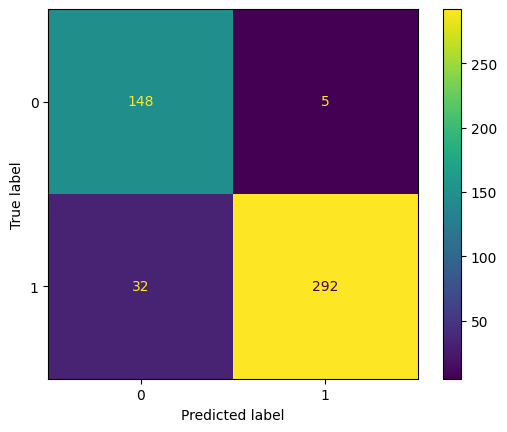

In [92]:
print(f"Scores for logistic regression model - OverSampled")
metric_scores(y_sm, logreg.predict(X_sm), data_type = "train")
metric_scores(y_test, logreg.predict(X_test_sca), data_type = "test")

with no oversampling in data

In [93]:
logreg1 = LogisticRegression(random_state = random_seed)
logreg1.fit(X_train_sca, y_train)

LogisticRegression(random_state=42)

Scores for logistic regression model - Basic
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9353991596638656
  precision_score = 0.9810699588477366
  recall_score = 0.9226006191950464
  f1_score = 0.9509373753490228
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9266247379454927
  precision_score = 0.9832775919732442
  recall_score = 0.9074074074074074
  f1_score = 0.9438202247191012
  roc_auc_score = 0.937363834422658
  Classification Report
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       153
           1       0.98      0.91      0.94       324

    accuracy                           0.93       477
   macro avg       0.91      0.94      0.92       477
weighted avg       0.93      0.93      0.93       477


  Confusion Matrix


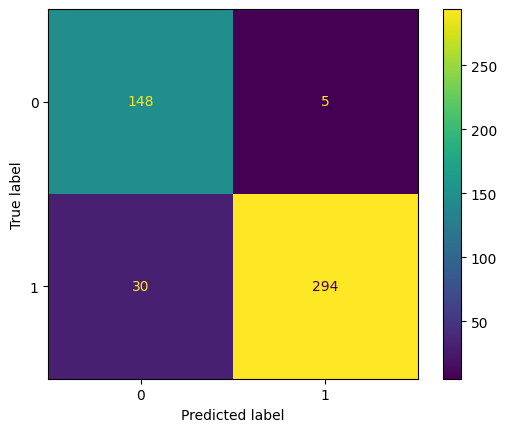

In [94]:
print(f"Scores for logistic regression model - Basic")
metric_scores(y_train, logreg1.predict(X_train_sca), data_type = "train")
metric_scores(y_test, logreg1.predict(X_test_sca), data_type = "test")

There is no much difference with respect to oversampling, this maybe due to the ratio between the majority to minority class being 67:33 (not so much dominating class), but we know logistic regression is impacted by imbalance in data. So, let's hypertune the model with oversampled data

Scores for logistic regression model (hyper parameters tuned)
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9485294117647058
  precision_score = 0.9769547325102881
  recall_score = 0.9187306501547987
  f1_score = 0.9469485440765856
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9203354297693921
  precision_score = 0.9798657718120806
  recall_score = 0.9012345679012346
  f1_score = 0.9389067524115756
  roc_auc_score = 0.9310094408133623
  Classification Report
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       153
           1       0.98      0.90      0.94       324

    accuracy                           0.92       477
   macro avg       0.90      0.93      0.91       477
weighted avg       0.93      0.92      0.92       477


  Confusion Matrix


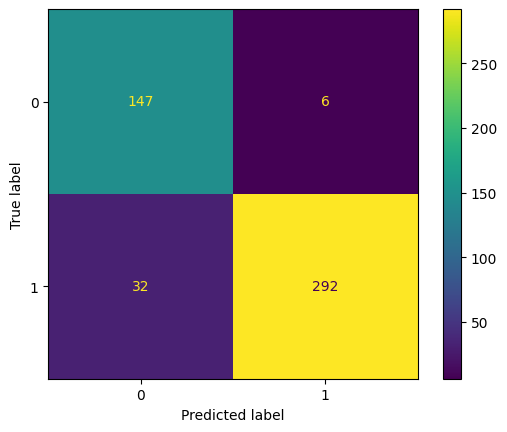

In [95]:
# c_values = np.arange(0.001, 1200, 10)

# param_grid = dict(C = c_values)

# logreg2 = grid_search_cv(LogisticRegression(random_state = random_seed, max_iter = 1000), param_grid, "f1", X_sm, y_sm, folds = 5)
logreg2 = LogisticRegression(random_state = random_seed, max_iter = 1000, C = 10.001)
logreg2.fit(X_sm, y_sm)

print(f"Scores for logistic regression model (hyper parameters tuned)")
metric_scores(y_sm, logreg2.predict(X_sm), data_type = "train")
metric_scores(y_test, logreg2.predict(X_test_sca), data_type = "test")

# best params = {'C': 10.001}

In [96]:
scores["LogisticRegression"] = {"no oversampling" : roc_auc_score(y_test, logreg1.predict(X_test_sca)),
                                    "oversampling" : roc_auc_score(y_test, logreg2.predict(X_test_sca))}

#### Decision Tree

with no oversampling

In [97]:
# criterion = ["gini", "log_loss"]
# max_depth = [_ for _ in range(5,70,5)]
# max_features = ["sqrt", "log2"]
# max_leaf_nodes = [_ for _ in range(10,80,10)]
# min_samples_leaf = [_ for _ in range(2,21,3)]
# ccp_alpha = [0.0001,0.001,0.1,1]

# param_grid = dict(criterion = criterion, max_depth = max_depth, ccp_alpha = ccp_alpha, max_features = max_features, max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf)

# decisionTreeClassifier1 = grid_search_cv(DecisionTreeClassifier(random_state = random_seed, splitter = "best", class_weight = "balanced"), param_grid, "f1", X_train, y_train, folds = 5)
decisionTreeClassifier1 = DecisionTreeClassifier(ccp_alpha = 0.0001, criterion = "log_loss", max_depth = 10, max_features = "sqrt", max_leaf_nodes = 40, min_samples_leaf = 8, random_state = random_seed, splitter = "best", class_weight = "balanced")
decisionTreeClassifier1.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0001, class_weight='balanced',
                       criterion='log_loss', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=40, min_samples_leaf=8, random_state=42)


Scores for Decision Tree Classifier model (hyper parameters tuned)
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9380252100840336
  precision_score = 0.989983305509182
  recall_score = 0.9179566563467493
  f1_score = 0.9526104417670683
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9245283018867925
  precision_score = 0.9768211920529801
  recall_score = 0.9104938271604939
  f1_score = 0.9424920127795527
  roc_auc_score = 0.932371096586783
  Classification Report
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       153
           1       0.98      0.91      0.94       324

    accuracy                           0.92       477
   macro avg       0.91      0.93      0.92       477
weighted avg       0.93      0.92      0.93       477


  Confusion Matrix


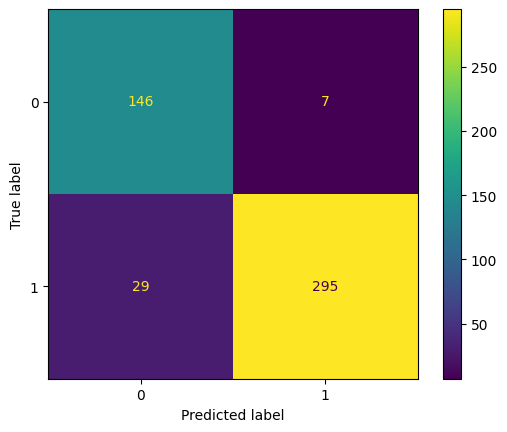

In [98]:
print(f"\nScores for Decision Tree Classifier model (hyper parameters tuned)")
metric_scores(y_train, decisionTreeClassifier1.predict(X_train), data_type = "train")
metric_scores(y_test, decisionTreeClassifier1.predict(X_test), data_type = "test")

with oversampling

In [99]:
smote = SMOTE(random_state = random_seed)
X_sm, y_sm = smote.fit_resample(X_train, y_train)
y_sm.value_counts()

churn
0    1292
1    1292
Name: count, dtype: int64

In [100]:
# decisionTreeClassifier2 = grid_search_cv(DecisionTreeClassifier(random_state = random_seed, splitter = "best", class_weight = "balanced"), param_grid, "f1", X_sm, y_sm, folds = 5)
decisionTreeClassifier2 = DecisionTreeClassifier(ccp_alpha = 0.001, criterion = "gini", max_depth = 15, max_features = "sqrt", max_leaf_nodes = 20, min_samples_leaf = 2, random_state = random_seed, splitter = "best", class_weight = "balanced")
decisionTreeClassifier2.fit(X_sm, y_sm)

# best params = {'ccp_alpha': 0.0001, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': 30, 'min_samples_leaf': 8} - 0.945

DecisionTreeClassifier(ccp_alpha=0.001, class_weight='balanced', max_depth=15,
                       max_features='sqrt', max_leaf_nodes=20,
                       min_samples_leaf=2, random_state=42)


Scores for Decision Tree Classifier model (hyper parameters tuned) - OverSampled
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9589783281733746
  precision_score = 0.9828990228013029
  recall_score = 0.9342105263157895
  f1_score = 0.957936507936508
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9308176100628931
  precision_score = 0.9770491803278688
  recall_score = 0.9197530864197531
  f1_score = 0.9475357710651828
  roc_auc_score = 0.9370007262164126
  Classification Report
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       153
           1       0.98      0.92      0.95       324

    accuracy                           0.93       477
   macro avg       0.91      0.94      0.92       477
weighted avg       0.94      0.93      0.93       477


  Confusion Matrix


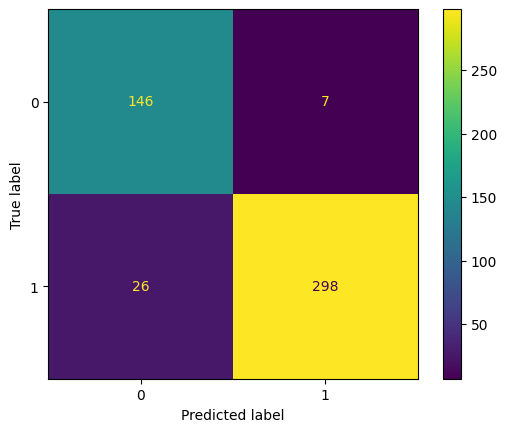

In [101]:
print(f"\nScores for Decision Tree Classifier model (hyper parameters tuned) - OverSampled")
metric_scores(y_sm, decisionTreeClassifier2.predict(X_sm), data_type = "train")
metric_scores(y_test, decisionTreeClassifier2.predict(X_test), data_type = "test")

In [102]:
scores["DecisonTreeClassifier"] = {"oversampling" : roc_auc_score(y_test, decisionTreeClassifier2.predict(X_test)),
                                    "no oversampling" : roc_auc_score(y_test, decisionTreeClassifier1.predict(X_test))}

#### RandomForestClassifier - Bagging

with no oversampling

In [103]:
# grid = {
#  "n_estimators" : [val for val in range (10,700, 80)],
#  "max_depth" : [int(x) for x in np.linspace(5,45,5)],
#  "min_samples_split" : [2, 5],
#  "min_samples_leaf" : [2, 4,8], 
#  "bootstrap" : [True, False],
#  "ccp_alpha" : [.1, .01, .001,.0001]
# }

# rfc_model1 = grid_search_cv(RandomForestClassifier(random_state = random_seed, class_weight = "balanced", n_jobs = -1), grid, "f1", X_train, y_train, folds = 5)
rfc_model1 = RandomForestClassifier(ccp_alpha=0.001, class_weight="balanced", max_depth=25, min_samples_leaf=2, n_estimators=170, n_jobs=-1, random_state= random_seed)
rfc_model1.fit(X_train, y_train)

# best params = {'bootstrap': True, 'ccp_alpha': 0.001, 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 170}

RandomForestClassifier(ccp_alpha=0.001, class_weight='balanced', max_depth=25,
                       min_samples_leaf=2, n_estimators=170, n_jobs=-1,
                       random_state=42)


Scores for RandomForest Classifier model (hyper parameters tuned) - no OverSampling
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9653361344537815
  precision_score = 0.9904
  recall_score = 0.958204334365325
  f1_score = 0.9740361919748229
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9350104821802935
  precision_score = 0.9741100323624595
  recall_score = 0.9290123456790124
  f1_score = 0.9510268562401264
  roc_auc_score = 0.9383623819898329
  Classification Report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       153
           1       0.97      0.93      0.95       324

    accuracy                           0.94       477
   macro avg       0.92      0.94      0.93       477
weighted avg       0.94      0.94      0.94       477


  Confusion Matrix


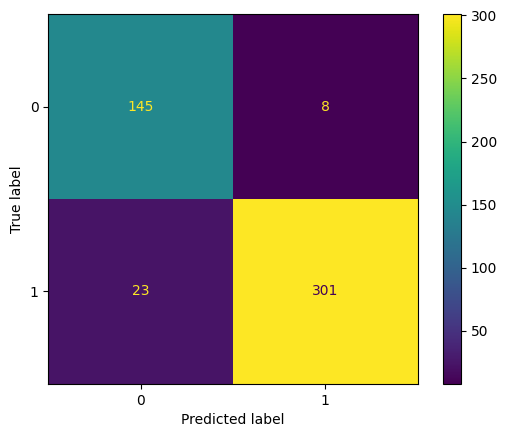

In [104]:
print(f"\nScores for RandomForest Classifier model (hyper parameters tuned) - no OverSampling")
metric_scores(y_train, rfc_model1.predict(X_train), data_type = "train")
metric_scores(y_test, rfc_model1.predict(X_test), data_type = "test")

with oversampling

In [105]:
rfc_model2 = RandomForestClassifier(ccp_alpha=0.001, class_weight='balanced_subsample',max_depth=25, min_samples_leaf=2, n_estimators=170,n_jobs=-1, random_state=42)
rfc_model2.fit(X_sm, y_sm)

RandomForestClassifier(ccp_alpha=0.001, class_weight='balanced_subsample',
                       max_depth=25, min_samples_leaf=2, n_estimators=170,
                       n_jobs=-1, random_state=42)


Scores for RandomForest Classifier model (hyper parameters tuned) - OverSampling
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9736842105263158
  precision_score = 0.9872611464968153
  recall_score = 0.9597523219814241
  f1_score = 0.9733124018838304
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.9308176100628931
  precision_score = 0.970873786407767
  recall_score = 0.9259259259259259
  f1_score = 0.9478672985781991
  roc_auc_score = 0.9335511982570807
  Classification Report
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       153
           1       0.97      0.93      0.95       324

    accuracy                           0.93       477
   macro avg       0.91      0.93      0.92       477
weighted avg       0.93      0.93      0.93       477


  Confusion Matrix


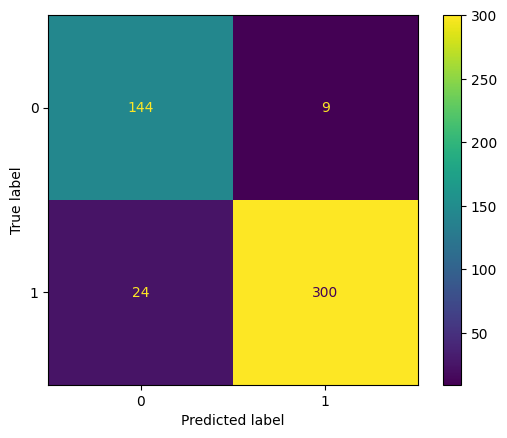

In [106]:
print(f"\nScores for RandomForest Classifier model (hyper parameters tuned) - OverSampling")
metric_scores(y_sm, rfc_model2.predict(X_sm), data_type = "train")
metric_scores(y_test, rfc_model2.predict(X_test), data_type = "test")

In [107]:
scores["RandomForestClassifier"] = {"oversampling" : roc_auc_score(y_test, rfc_model2.predict(X_test)),
                                    "no oversampling" : roc_auc_score(y_test, rfc_model1.predict(X_test))}

#### XGBoost - Boosting

with no oversampling

In [108]:
# params = {
#  "colsample_bytree": np.arange(0.5,1.0,1.0),
#  "learning_rate": [0.1,0.3,0.5,0.7], 
#  "max_depth": range(1,20,2), 
#  "n_estimators": range(5,100,10), 
#  "subsample": np.arange(0.5,1.0,1),
#  "gamma":[0.1,0.3,0.5],
#  "reg_lambda":[0.1,0.3,0.5]
# }

# xgb_model1 = grid_search_cv(XGBClassifier(random_state = random_seed), grid, "f1", X_train, y_train, folds = 5)
xgb_model1 = XGBClassifier(random_state = random_seed, bootstrap = True, ccp_alpha = 0.1, max_depth = 5, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 10)
xgb_model1.fit(X_train, y_train)

# best params = {'bootstrap': True, 'ccp_alpha': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}

XGBClassifier(base_score=None, booster=None, bootstrap=True, callbacks=None,
              ccp_alpha=0.1, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, min_samples_leaf=2, min_samples_split=2,
              missing=nan, monotone_constraints=None, multi_strategy=None, ...)


Scores for XGBoost Classifier model (hyper parameters tuned) - no OverSampling
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9642857142857143
  precision_score = 0.9788732394366197
  recall_score = 0.968266253869969
  f1_score = 0.9735408560311284
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.939203354297694
  precision_score = 0.9652996845425867
  recall_score = 0.9444444444444444
  f1_score = 0.9547581903276131
  roc_auc_score = 0.9362745098039217
  Classification Report
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       153
           1       0.97      0.94      0.95       324

    accuracy                           0.94       477
   macro avg       0.93      0.94      0.93       477
weighted avg       0.94      0.94      0.94       477


  Confusion Matrix


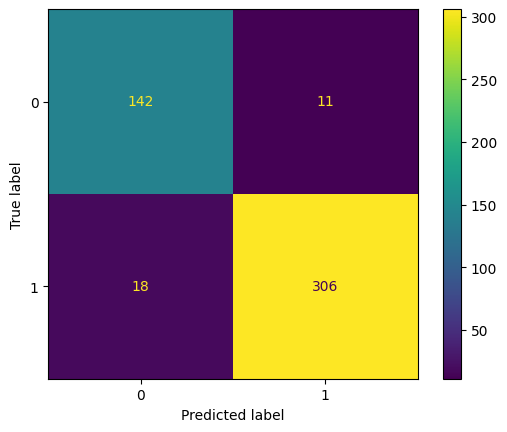

In [109]:
print(f"\nScores for XGBoost Classifier model (hyper parameters tuned) - no OverSampling")
metric_scores(y_train, xgb_model1.predict(X_train), data_type = "train")
metric_scores(y_test, xgb_model1.predict(X_test), data_type = "test")

with oversampling

In [110]:
xgb_model2 = XGBClassifier(bootstrap = True, ccp_alpha = 0.1, max_depth = 5, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 10, random_state = random_seed)
xgb_model2.fit(X_sm, y_sm)

XGBClassifier(base_score=None, booster=None, bootstrap=True, callbacks=None,
              ccp_alpha=0.1, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, min_samples_leaf=2, min_samples_split=2,
              missing=nan, monotone_constraints=None, multi_strategy=None, ...)


Scores for XGBoost Classifier model (hyper parameters tuned) - OverSampling
----------------------------------------------------------------------
train data results:
  accuracy_score = 0.9698142414860681
  precision_score = 0.9856
  recall_score = 0.9535603715170279
  f1_score = 0.969315499606609
----------------------------------------------------------------------
test data results:
  accuracy_score = 0.939203354297694
  precision_score = 0.9742765273311897
  recall_score = 0.9351851851851852
  f1_score = 0.9543307086614172
  roc_auc_score = 0.9414488017429193
  Classification Report
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       153
           1       0.97      0.94      0.95       324

    accuracy                           0.94       477
   macro avg       0.92      0.94      0.93       477
weighted avg       0.94      0.94      0.94       477


  Confusion Matrix


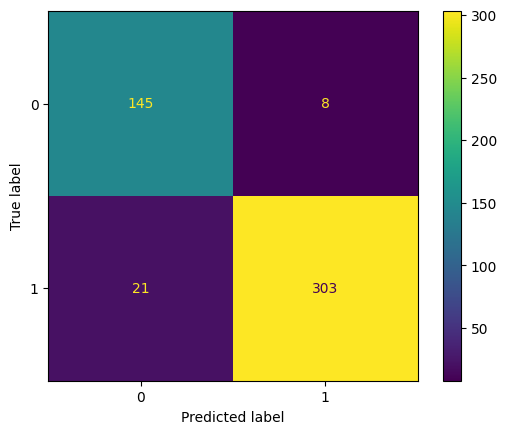

In [111]:
print(f"\nScores for XGBoost Classifier model (hyper parameters tuned) - OverSampling")
metric_scores(y_sm, xgb_model2.predict(X_sm), data_type = "train")
metric_scores(y_test, xgb_model2.predict(X_test), data_type = "test")

In [112]:
scores["XGBoostClassifier"] = {"oversampling" : roc_auc_score(y_test, xgb_model2.predict(X_test)),
                                    "no oversampling" : roc_auc_score(y_test, xgb_model1.predict(X_test))}

#### best model

In [113]:
scores_df = pd.DataFrame(scores.values(), index = scores.keys())
scores_df.sort_values(by = ["oversampling", "no oversampling"], ascending = False)

,no oversampling,oversampling
XGBoostClassifier,0.936275,0.941449
DecisonTreeClassifier,0.932371,0.937001
RandomForestClassifier,0.938362,0.933551
LogisticRegression,0.937364,0.931009


- XGBoostClassifier with oversampling gives the best result

feature importance

In [114]:
importances = xgb_model2.feature_importances_
feature_importance = pd.DataFrame(list(zip(list(X_train.columns), list(importances))), columns = ["feature", "importances"]).set_index("feature")
feature_importance

,importances
feature,
Income_mean,0.008127
Income_last,0.000000
Total Business Value_sum,0.021117
Total Business Value_min,0.011297
Total Business Value_max,0.009917
Total Business Value_mean,0.002744
Total Business Value_last,0.028495
City_last,0.006402
Education_Level_last,0.008159


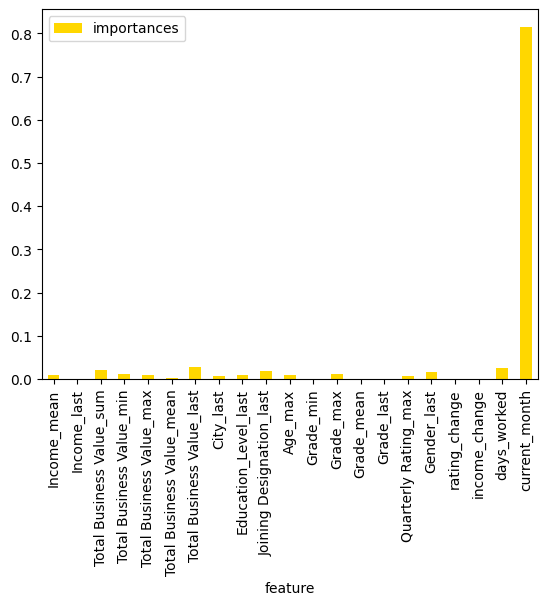

In [115]:
fig, ax = plt.subplots()
feature_importance.plot.bar(ax=ax, color = "gold")
plt.show()

- current month is the most important feature

Recommendations

1. The employees whose quarterly rating has increased are less likely to leave the organization
2. drivers whose monthly salary is not increased is likely to churn (so any incentive or rewards can be given)

In [116]:
import pickle


In [117]:
with open('churn_model.pkl', 'wb') as file:
    pickle.dump(xgb_model2, file)